# Using Autoencoders for Lunar Seismic Data 

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import os

2024-10-06 19:35:42.590246: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 19:35:42.682178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 19:35:42.719394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 19:35:42.730303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 19:35:42.797703: I tensorflow/core/platform/cpu_feature_guar

### Loading the data chunks that we extracted from the previous notebook

In [42]:
# Function to load and preprocess the CSV file (extracting velocity values)
def load_and_preprocess_csv(file_path):
    df = pd.read_csv(file_path, header=None)
    # Extract the third column (velocity values) and remove the header
    data = df.iloc[1:, 2].astype(float).values
    # Ensure the length matches 11,880
    if len(data) == 11880:
        return data
    else:
        print(f"File {file_path} has length {len(data)}. Expected length is 11,880.")
        return None

# Set the directory containing your .csv files
data_dir = './data/lunar/training/cuts-vae'  # Replace with your directory path

# List all .csv files in the directory
file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]

# Initialize an empty list to store the data
data_list = []

# Read and preprocess each .csv file and append the data to the list
for file in file_list:
    data = load_and_preprocess_csv(file)
    if data is not None:
        data_list.append(data)


data_dir_anomalies = './data/lunar/training/anomalies-vae'  # Replace with your directory path

# List all .csv files in the directory
file_list_anomalies = [os.path.join(data_dir_anomalies, f) for f in os.listdir(data_dir_anomalies) if f.endswith('.csv')]

# Initialize an empty list to store the data
data_list_anomalies = []

for file in file_list_anomalies:
    data = load_and_preprocess_csv(file)
    if data is not None:
        data_list_anomalies.append(data)

print("Dataset Loaded")

Dataset Loaded


In [4]:
print(data_list[0])

[-2.11393503e-12 -1.15935448e-12 -7.14978812e-13 ...  1.06392361e-12
  1.06392361e-12  1.06392361e-12]


In [5]:
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

Normalize the data to `[0,1]`. And use Scaler to increase values to try to make the autoencoder escape from reconstruct values that are too close for the mean.


In [44]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
# test_data = (test_data - min_val) / (max_val - min_val)

normal_train_data = tf.cast(train_data, tf.float32)
# normal_test_data = tf.cast(test_data, tf.float32)


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
normal_train_data_scaled = scaler.fit_transform(normal_train_data)
test_data_scaled = scaler.transform(test_data)
anomaly_data_scaled = scaler.transform(data_list_anomalies)


print(len(normal_train_data), normal_train_data.shape)

1452 (1452, 11880)


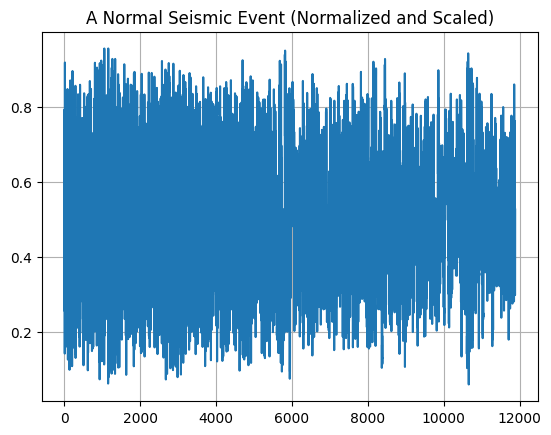

In [46]:
plt.grid()
plt.plot(np.arange(11880), normal_train_data_scaled[5])
plt.title("A Normal Seismic Event (Normalized and Scaled)")
plt.show()

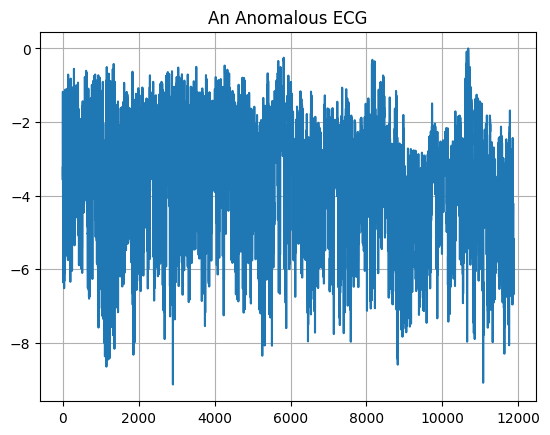

In [47]:
plt.grid()
plt.plot(np.arange(11880), anomaly_data_scaled[11])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [24]:
# class AnomalyDetector(Model):
#   def __init__(self):
#     super(AnomalyDetector, self).__init__()
#     self.encoder = tf.keras.Sequential([
#       layers.Dense(32, activation="relu"),
#       layers.Dense(16, activation="relu"),
#       layers.Dense(8, activation="relu")])

#     self.decoder = tf.keras.Sequential([
#       layers.Dense(16, activation="relu"),
#       layers.Dense(32, activation="relu"),
#       layers.Dense(140, activation="sigmoid")])

#   def call(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

# autoencoder = AnomalyDetector()

# class AnomalyDetector(Model):
#     def __init__(self):
#         super(AnomalyDetector, self).__init__()

#         # Encoder
#         self.encoder = tf.keras.Sequential([
#             layers.Dense(512, activation="relu", input_shape=(11880,)),
#             layers.Dense(256, activation="relu"),
#             layers.Dense(128, activation="relu")
#         ])

#         # Decoder
#         self.decoder = tf.keras.Sequential([
#             layers.Dense(256, activation="relu"),
#             layers.Dense(512, activation="relu"),
#             layers.Dense(11880, activation="sigmoid")
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

class ImprovedAnomalyDetector(Model):
    def __init__(self):
        super(ImprovedAnomalyDetector, self).__init__()

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(512, activation="relu", input_shape=(11880,)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(256, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(128, activation="relu"),
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(512, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(11880, activation="linear")  # Linear activation to match raw output
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class ConvAutoencoder(Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Reshape((11880, 1), input_shape=(11880,)),
            layers.Conv1D(64, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(2, padding='same'),
            layers.Conv1D(32, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(2, padding='same'),
            layers.Conv1D(16, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(2, padding='same'),
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Conv1D(16, 3, activation='relu', padding='same'),
            layers.UpSampling1D(2),
            layers.Conv1D(32, 3, activation='relu', padding='same'),
            layers.UpSampling1D(2),
            layers.Conv1D(64, 3, activation='relu', padding='same'),
            layers.UpSampling1D(2),
            layers.Conv1D(1, 3, activation='sigmoid', padding='same'),
            layers.Reshape((11880,))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# class AnomalyDetectorLSTM(Model):
#     def __init__(self):
#         super(AnomalyDetectorLSTM, self).__init__()

#         # Encoder
#         self.encoder = tf.keras.Sequential([
#             layers.Reshape((11880, 1)),  # Reshaping to 3D for LSTM
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.LSTM(64, activation="relu"),
#             layers.Dense(32, activation="relu")  # Latent space
#         ])

#         # Decoder
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(11880),  # Repeat the latent vector for each timestep
#             layers.LSTM(64, activation="relu", return_sequences=True),
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.TimeDistributed(layers.Dense(1, activation="sigmoid")),  # Output sequence
#             layers.Flatten()  # Flatten to match the input shape
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Reshape((11880, 1)),  # Reshaping to 3D for GRU
            layers.GRU(128, activation="relu", return_sequences=True),
            layers.GRU(64, activation="relu"),
            layers.Dense(32, activation="relu")  # Latent space
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(11880),  # Repeat the latent vector for each timestep
            layers.GRU(64, activation="relu", return_sequences=True),
            layers.GRU(128, activation="relu", return_sequences=True),
            layers.TimeDistributed(layers.Dense(1, activation="sigmoid")),  # Output sequence
            layers.Flatten()  # Flatten to match the input shape
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class ConvAutoencoder(Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Reshape((11880, 1), input_shape=(11880,)),
            layers.Conv1D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv1D(128, 3, activation='relu', padding='same', strides=2),
            layers.BatchNormalization(),
            
            layers.Conv1D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            layers.BatchNormalization(),
            
            layers.Conv1D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv1D(32, 3, activation='relu', padding='same', strides=2),
            layers.BatchNormalization(),
            
            layers.Conv1D(16, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv1D(16, 3, activation='relu', padding='same', strides=2),
            layers.BatchNormalization(),
            
            layers.Flatten(),
            layers.Dense(256, activation='relu'),  # Latent space
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(743 * 16, activation='relu', input_shape=(256,)),
            layers.Reshape((743, 16)),
            
            layers.Conv1DTranspose(16, 3, activation='relu', padding='same', strides=2),
            layers.BatchNormalization(),
            layers.Conv1D(16, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            
            layers.Conv1DTranspose(32, 3, activation='relu', padding='same', strides=2),
            layers.BatchNormalization(),
            layers.Conv1D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            
            layers.Conv1DTranspose(64, 3, activation='relu', padding='same', strides=2),
            layers.BatchNormalization(),
            layers.Conv1D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            
            # Adjusted stride to 1 and added UpSampling
            layers.Conv1DTranspose(128, 3, activation='relu', padding='same', strides=1),
            layers.BatchNormalization(),
            layers.Conv1D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.UpSampling1D(size=2),
            layers.Conv1D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            
            layers.Conv1D(1, 3, activation='sigmoid', padding='same'),
            layers.Cropping1D(cropping=(4, 4)),  # Adjusts length to 11880
            layers.Flatten(),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# autoencoder = ConvAutoencoder()

autoencoder = ImprovedAnomalyDetector()

# Instantiate and compile the model
# autoencoder = ImprovedAnomalyDetector()
# Instantiate the model
# autoencoder = AnomalyDetector()
# autoencoder = AnomalyDetectorLSTM()

# Instantiate the model
# autoencoder = AnomalyDetector()


In [25]:
autoencoder.compile(optimizer='adam', loss='mse')

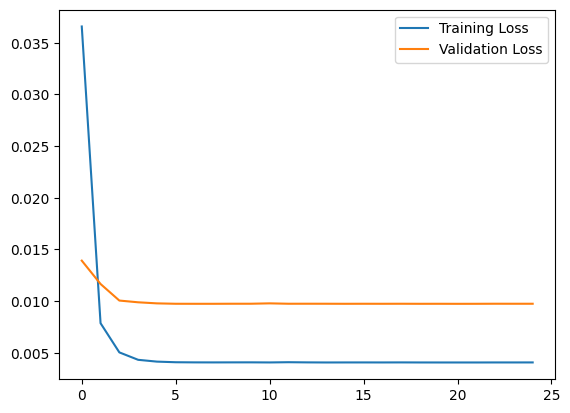

In [33]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold.


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 
tf.Tensor([0.13431427 0.13419051 0.1340397  ... 0.13413423 0.13416418 0.13405001], shape=(1452,), dtype=float32)


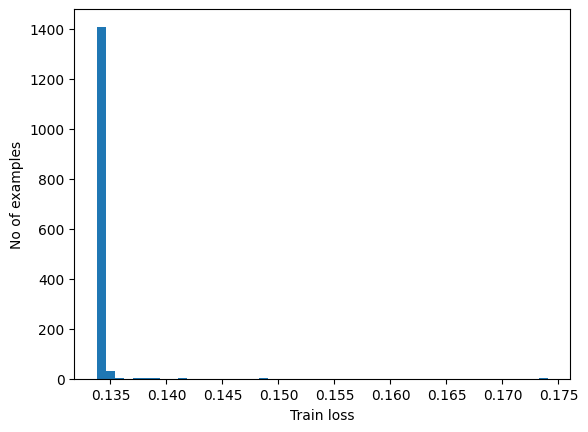

In [50]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

print(train_loss)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [51]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.13538113


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


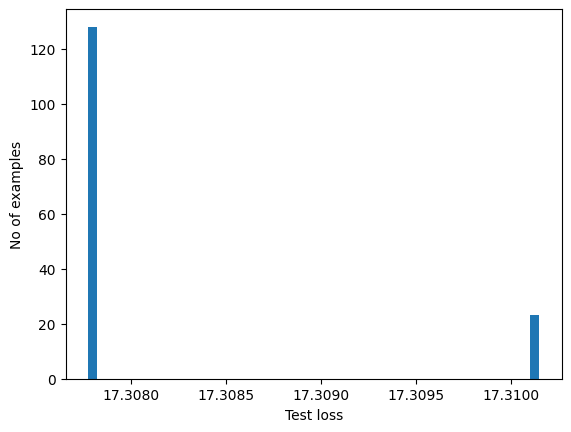

In [52]:
reconstructions = autoencoder.predict(anomaly_data_scaled)
test_loss = tf.keras.losses.mae(reconstructions, anomaly_data_scaled)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify the seismic data as an anomaly if the reconstruction error is greater than the threshold. As we can see, the anomalies can be classified from a threshold of error. We tried a different number of autoencoder architectures, but we could note get a really good accuracy. Maybe a VAE would do better here, or some other data processing technique.